# Analyse der Layer-Anzahl für Multi-layered Perceptrons

In diesem Notebook analysieren wir die Leistung eines Multi-layered Perceptrons (MLP) basierend auf
verschiedenen Größen der Hidden-Layers. Wir erwarten, dass dieser Parameter einen erheblichen
Einfluss auf die Leistungsmetriken des Modell hat.

Als Basis verwenden wir das `sizes`-Array, welches die folgenden Größen annimmt:

$$\{ (1,1),~(1,10),~(1,20),~\ldots,~(1,50),~(10,1),~(10,10),~\ldots,~(10,50),~\ldots,~(100,50)\}$$

Wir kommen zum Schluss, dass die beste Präzision von 92,59% bei einer Größe von $(80,20)$ erreicht
wird. Der F1-Score liegt dabei bei soliden 0,87.

**Hinweis**: Das Trainieren der Modelle hat sehr lange gedauert (ca. 7 Stunden). Daher wurden die
Arrays mit den Metriken gespeichert. Unten ist eine auskommentierte Zelle enthalten, um diese
wieder einzulesen. Somit müssen die Modelle nicht erneut trainiert werden.

In [13]:
max_file_count = None
none_replacement = 'all'

RANDOM_STATE = 42

## FFT Daten laden

🔗 siehe [generate.ipynb](../generate.ipynb)

In [3]:
import numpy as np
import os

feature_matrix = np.load(os.path.join(os.pardir,
                                      f'feature_{max_file_count or none_replacement}.npy'))

labels = np.load(os.path.join(os.pardir,
                              f'labels_{max_file_count or none_replacement}.npy'))

feature_matrix = np.abs(feature_matrix)

## Aufteilung in Trainings- und Testdaten

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels,
                                                    test_size=0.2, random_state=RANDOM_STATE)

In [5]:
print(X_train.shape)
print(X_test.shape)

(31697, 22050)
(7925, 22050)


In [14]:
LABEL_NO_WHISTLE = -1
LABEL_WHISTLE = 1

## Analyse der Layer

In [3]:
# get possible sizes from (1,1) to (100,50) with step length 10
sizes = []
for i in range(0, 100 + 10, 10):
    for j in range(0, 50 + 10, 10):
        sizes.append([max(1, i), max(1, j)])
sizes = np.array(sizes)

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from tqdm import tqdm

accuracies = []
precisions = []
recalls = []
f1s = []

for size in tqdm(sizes, unit='size'):
    model = MLPClassifier(hidden_layer_sizes=size, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    
    y_test_predict = model.predict(X_test)
    
    # proportion of correct predictions
    accuracies.append(metrics.accuracy_score(y_test, y_test_predict))
    
    # proportion of true positives under all positives
    precisions.append(metrics.precision_score(y_test, y_test_predict, zero_division=0))
    
    # proportion of true positives under actually positives
    recalls.append(metrics.recall_score(y_test, y_test_predict))
    
    # total performance
    f1s.append(metrics.f1_score(y_test, y_test_predict))

accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)

np.save('accuracies.npy', accuracies)
np.save('precisions.npy', precisions)
np.save('recalls.npy', recalls)
np.save('f1s.npy', f1s)

100%|██████████| 66/66 [7:12:37<00:00, 393.30s/size]   


In [2]:
# import numpy as np

# accuracies = np.load('accuracies.npy')
# precisions = np.load('precisions.npy')
# recalls = np.load('recalls.npy')
# f1s = np.load('f1s.npy')

In [17]:
size_best_f1 = sizes[np.argmax(f1s)]
size_best_recall = sizes[np.argmax(recalls)]
size_best_precision = sizes[np.argmax(precisions)]

print(f'best f1:        {np.max(f1s):.4f} with size {size_best_f1}')
print(f'best recall:    {np.max(recalls):.4f} with size {size_best_recall}')
print(f'best precision: {np.max(precisions):.4f} with size {size_best_precision}')

best f1:        0.8531 with size [90 50]
best recall:    0.8493 with size [ 1 20]
best precision: 0.9259 with size [80 20]


In [18]:
print(f'precision at best f1: {precisions[np.argmax(f1s)]:.2f}')
print(f'f1 at best precision: {f1s[np.argmax(precisions)]:.2f}')

precision at best f1: 0.87
f1 at best precision: 0.79


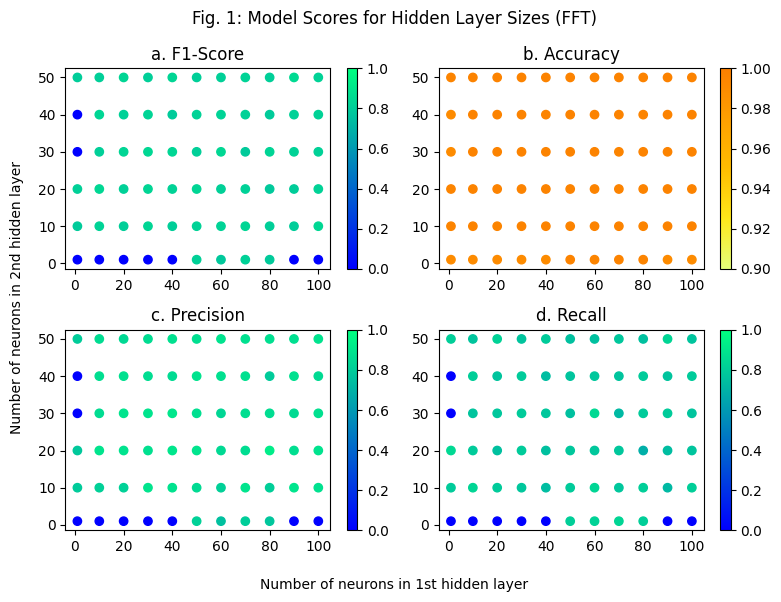

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scipy.interpolate

fig, axs = plt.subplots(2, 2, figsize=(8,6))
cmap = 'winter'

norm = Normalize(vmin=0, vmax=1)

scatter_f1 = axs[0, 0].scatter(sizes[:, 0], sizes[:, 1], c=f1s, cmap=cmap, norm=norm)
fig.colorbar(scatter_f1, ax=axs[0, 0])
axs[0, 0].set_title('a. F1-Score')

scatter_accs = axs[0, 1].scatter(sizes[:, 0], sizes[:, 1], c=accuracies, cmap='Wistia',
                                 norm=Normalize(vmin=0.9, vmax=1))
fig.colorbar(scatter_accs, ax=axs[0, 1])
axs[0, 1].set_title('b. Accuracy')

scatter_precs = axs[1, 0].scatter(sizes[:, 0], sizes[:, 1], c=precisions, cmap=cmap, norm=norm)
fig.colorbar(scatter_precs, ax=axs[1, 0])
axs[1, 0].set_title('c. Precision')

scatter_recs = axs[1, 1].scatter(sizes[:, 0], sizes[:, 1], c=recalls, cmap=cmap, norm=norm)
fig.colorbar(scatter_recs, ax=axs[1, 1])
axs[1, 1].set_title('d. Recall')

fig.suptitle('Fig. 1: Model Scores for Hidden Layer Sizes (FFT)')
fig.supxlabel('Number of neurons in 1st hidden layer', fontsize=10)
fig.supylabel('Number of neurons in 2nd hidden layer', fontsize=10)

fig.tight_layout()

plt.savefig('plot.png')
plt.show()

In Fig. 1 sind die Leistungsmetriken der Modelle basierend auf den verschiedenen Hidden-Layer-Größen
dargestellt. In Subfig. 1a. wird deutlich, dass der F1-Score bei einer Größe von mindestens 10 pro
Schicht sehr gut aussieht (mit einigen Ausnahmen). Ähnlich verhält es sich mit der Präzision, dem
Recall und der Genauigkeit.

Im Real-Szenario sieht es wie folgt aus. Es ist für die Roboter besser, einen tatsächlich
aufgetretenen Pfiff *nicht* zu erkennen, als eine Sekunde, in der kein Pfiff war, als Pfiff zu
klassifizieren. Dementsprechend wollen wir die False-Positives minimieren. Somit optimieren wir
im folgenden die Präzision anstelle des Recalls.

Daher wird im Folgenden das resultierende Modell mit der Hidden-Layer-Größe von $(80,20)$ trainiert.
Dort wird der Maximalwert der Präzision von 92,59% erreicht.

## Resultierendes Modell mit bester Performance

In [12]:
print(f'train model with size {size_best_precision}')

# train model
model = MLPClassifier(hidden_layer_sizes=size_best_precision, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

train model with size [80 20]


MLPClassifier(hidden_layer_sizes=array([80, 20]), random_state=42)

In [13]:
import skops.io as sio
sio.dump(model, f'mlp_layer.skops')

In [14]:
# generate predictions for test data
y_test_predict = model.predict(X_test)

In [15]:
print(f'#correct predictions: {y_test[y_test == y_test_predict].shape[0]}')
print(f'#false predictions:   {y_test[y_test != y_test_predict].shape[0]}')

#correct predictions: 7898
#false predictions:   27


In [16]:
print(f'#real whistles:      {y_test[y_test == LABEL_WHISTLE].shape[0]}')
print(f'#predicted whistles: {y_test_predict[y_test == LABEL_WHISTLE].shape[0]}')

#real whistles:      73
#predicted whistles: 73


In [17]:
print(f'#real no whistles:      {y_test[y_test == LABEL_NO_WHISTLE].shape[0]}')
print(f'#predicted no whistles: {y_test_predict[y_test == LABEL_NO_WHISTLE].shape[0]}')

#real no whistles:      7852
#predicted no whistles: 7852


In [18]:
# proportion of correct predictions
print(f'accuracy:  {metrics.accuracy_score(y_test, y_test_predict):.4f}')

# proportion of true positives under all positives
print(f'precision: {metrics.precision_score(y_test, y_test_predict):.4f}')

# proportion of true positives under actually positives
print(f'recall:    {metrics.recall_score(y_test, y_test_predict):.4f}')

# total performance
print(f'f1:        {metrics.f1_score(y_test, y_test_predict):.4f}')

accuracy:  0.9966
precision: 0.9259
recall:    0.6849
f1:        0.7874


In [19]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      7852
           1       0.93      0.68      0.79        73

    accuracy                           1.00      7925
   macro avg       0.96      0.84      0.89      7925
weighted avg       1.00      1.00      1.00      7925



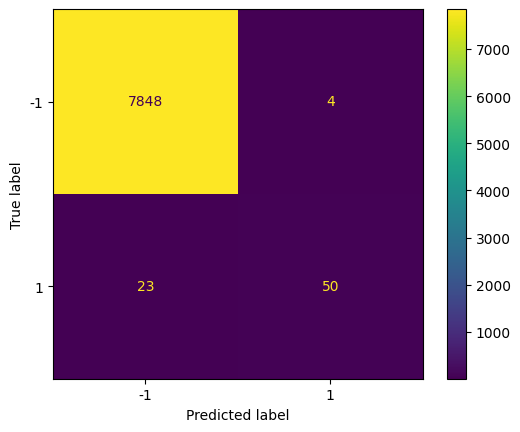

In [20]:
_ = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)

In [21]:
# relative confusion matrix
print(metrics.confusion_matrix(y_test, y_test_predict) / y_test.shape[0])

[[9.90283912e-01 5.04731861e-04]
 [2.90220820e-03 6.30914826e-03]]
